In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Some Useful Analysis Routines


In [ ]:
def ensemble_mean(series):
    return np.mean(series,axis=0)

def ensemble_var(series):
    return np.var(series,axis=0)

def lagged_covariance(series, lag, mean=None):
    assert lag>0
    
    if mean is None:
        mu = ensemble_mean(series)
    else:
        mu = mean
        
    s = series - mu # Super wasteful on memory
    return np.mean( s[:,:-lag]*s[:,lag:], axis=0)

# Again, super wasteful that I'm going to compute the mean many times
def lagged_covariance_matrix(series, max_lag, mean=None):
    assert max_lag < series.shape[-1]
    mat = []
    for l in range(1,max_lag):
        mat.append(lagged_covariance(series,l,mean))
    return mat


# Simulating MA models
A standard MA(q) (moving average) model represents a simple case where a time-series is an weighted average over some noise history, and has the form

$$ \hat{y}_{t} = \mu + \hat{\eta}_t + \sum_{l=1}^{q}\theta_l\hat{\eta}_{t-l} $$

where $y_t$ is our time series, $\mu \in \mathbb{R}$, $\theta_l \in \mathbb{R}$, and $\eta_t$ are i.i.d. random variables.  For simplicity, here we assume that $\langle\eta_t\rangle = 0$, where $\langle\cdot\rangle$ denotes the ensemble average.  This allows us to interpret $\mu$ as the mean of the series $\hat{y}_t$.

For notational convenience, we have denoted random parameters with a hat $\hat{\cdot}$, and used the subscript $l$ to indicate the *lag*.

We can also rewrite the above be introducing the lag operator $L$ that acts as

$$ L\eta_t = \eta_{t-1}$$

so that

$$ \hat{y}_t = \mu + \sum_{l=0}^q\theta_lL^l\eta_t $$

where for convenience we have defined $\theta_0 = 1$.  Of course, this normalization choice is simply a convention we can impose by rescaling all of the noise terms by $\theta_0^{-1}$.

To specify an MA(q) model, we must therefore provide:
 1. The value $q$ encoding the non-locality of the model (i.e. how many lags the model averages over)
 2. The vector of weights $\vec{\theta} \in \mathbb{R}^{q+1}$
 3. The statistics of the "white noise" $\eta_t$.
 4. The mean $\mu$
 
## Properties of MA distributions
It is straightforward to determine various mean statistical properties of the MA time-streams.  Since these distributions are stationary, these ensemble averages can be replaced by temporal averages (over an infinitely long time stream)

$$ \langle y_t \rangle = \mu $$
$$ \langle y_t^2 \rangle = \sigma^2_\eta \left(1 + \sum_{l=0}^q\theta_l^2 \right) = \sigma^2_\eta \sum_{l=0}^q \theta_l^2 $$
$$ \langle y_{t}y_{t-s} \rangle = \theta_s + \sum_{i=1}^{q-s}\theta_i\theta_{i+s} = \sum_{i=0}^{q-s}\theta_i\theta_{i+s} \qquad 0\leq s \leq q $$ 

In [36]:
def generate_samples_ma(num_samples, num_steps, *, ma_coeffs=np.array([0.1,0.2,0.4]), mu=0.):
    ma_coeffs = np.array(ma_coeffs)
    q = ma_coeffs.size
    
    noise = np.random.normal(size=(num_samples, num_steps+q))
    streams = np.zeros((num_samples, num_steps))
    
    for i in range(num_steps):
        streams[:,i] = mu + noise[:,i+q] + np.sum(ma_coeffs*noise[:,i:i+q],axis=-1)
    
    return streams[:,q:]


In [43]:
s = generate_samples_ma(10000, 32)

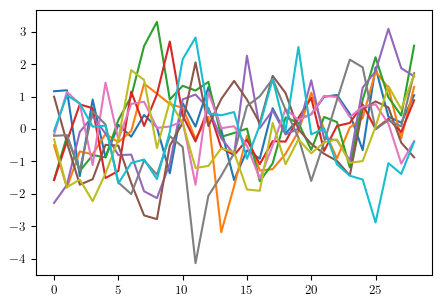

In [44]:
for s_ in s[:10]:
    plt.plot(s_)

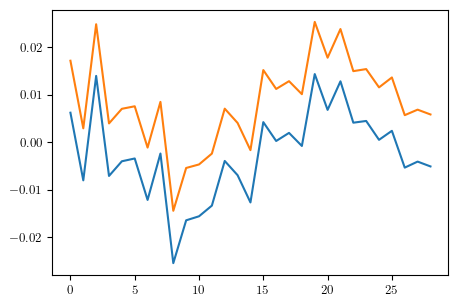

In [47]:
plt.plot( np.mean(s,axis=0) )
plt.plot( np.mean(s,axis=0) + np.std(s,axis=0)/np.sqrt(s.shape[0]) )

(array([  3.,   2.,   5.,   8.,  14.,  17.,  19.,  44.,  57.,  67.,  99.,
        130., 158., 205., 228., 306., 365., 408., 412., 475., 520., 560.,
        596., 571., 549., 574., 555., 476., 447., 384., 333., 293., 281.,
        206., 178., 133.,  78.,  85.,  46.,  34.,  25.,  20.,  14.,   6.,
          7.,   0.,   4.,   1.,   1.,   0.,   1.]),
 array([-3.77608581, -3.61593768, -3.45578954, -3.29564141, -3.13549328,
        -2.97534515, -2.81519702, -2.65504889, -2.49490076, -2.33475263,
        -2.1746045 , -2.01445637, -1.85430824, -1.69416011, -1.53401198,
        -1.37386385, -1.21371572, -1.05356759, -0.89341946, -0.73327133,
        -0.5731232 , -0.41297507, -0.25282694, -0.09267881,  0.06746932,
         0.22761745,  0.38776558,  0.54791371,  0.70806184,  0.86820997,
         1.0283581 ,  1.18850623,  1.34865436,  1.50880249,  1.66895062,
         1.82909875,  1.98924688,  2.14939501,  2.30954314,  2.46969127,
         2.6298394 ,  2.78998753,  2.95013566,  3.11028379,  3.27043

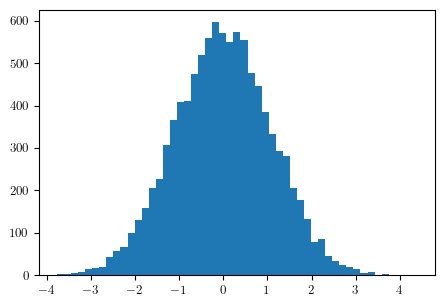

In [48]:
plt.hist(s[:,-1],51)

# Simulating AR(p) Models
AR(p) (autoregressive) models instead are a simple representation of the case where the evolution of a time-series depends on its past values along with some instantaneous noise.  The standard form is

$$ \hat{y}_t = \varphi_0 + \sum_{l=1}^p\varphi_l\hat{y}_{t-l} + \eta_t = \varphi_0 + \sum_{l=1}^p \varphi_l L^ly_t + \eta_t$$

Subject to some assumptions on the coefficients $\varphi_i$, these models are weakly stationary, with mean value given by

$$ \mu \equiv \langle \hat{y}_t \rangle = \frac{\varphi_0}{1-\sum_{l=1}^p\varphi_l} $$

If we assume weak stationarity, then the preceding result is trivial to derive by simply taking expectation values on both sides of the recurrence relation.

**Question**: Are they stationary, or just weakly stationary?

Using this result, we can rewrite the generating equation as

$$ \hat{y}_t - \mu = \sum_{l=1}^p\varphi_l\left(\hat{y}_{t-l}-\mu\right) + \eta_t $$

In some special cases, we can also obtain analytic expressions for the variance and lagged covariance (and therefore correlation) of the series.  The easiest case is when $p=1$, where we have

$$ \langle (\hat{y}_t-\mu)^2\rangle = \frac{\sigma^2_\eta}{1-\varphi_1^2} \equiv \sigma^2 $$
$$ \langle (\hat{y}_t-\mu)(\hat{y}_{t-l}-\mu)\rangle = \sigma^2\varphi_1^l = \left(\frac{\varphi_1^l}{1-\varphi_1^2}\right)\sigma^2_\eta $$

**Question**: Did I make an assumption about $\theta_0$ here?

**To Do**: Put in the polynomial we need to solve for the more general case.

Here we implement a simple Python function to generate samples from an AR(p) model.  This is not meant to be an optimised version, and various testing related to the ordering of variables, ways to remove the loop, etc. should be done to see what the most efficient approach is.

Some obvious improvements are:
 1. Allowing for user specified noise distributions
 2. Allowing for different options to "start" the series

In [ ]:
def generate_samples_ar(num_samples, num_steps, *, ar_coeffs=np.array([0.3]), phi0=0.7):
    p = ar_coeffs.size
    
    #noise = np.random.uniform(low=-0.5, high=0.5, size=(num_samples, num_steps))
    noise = np.random.normal(size=(num_samples, num_steps))
    
    y = np.zeros((num_samples, num_steps+p))
    y[:,:p] = phi0 / (1.- np.sum(ar_coeffs))
    #y[:,:p] = np.random.uniform(size=ar_ord)
    
    for i in range(num_steps):
        y[:,i+p] = phi0 + np.sum(y[:,i:i+p]*ar_coeffs,axis=-1) + noise[:,i]
    
    return y[:,p:]

def mean_ar(ar_coeffs, phi0):
    return phi0 / (1.-np.sum(ar_coeffs))

def variance_ar(ar_coeffs, phi0):
    return


In [ ]:
ar_coeffs = np.array([0.6])
phi0 = 0.

y = generate_samples_ar(10000, 64, ar_coeffs=ar_coeffs, phi0=phi0)

In [ ]:
# Plot a few sample trajectories
for _ in range(5):
    plt.plot(y[_])

plt.ylabel(r'$\hat{y}_t$')
plt.xlabel(r'Time Step')
plt.show()

In [ ]:
sig = np.std(y,axis=0) / np.sqrt(y.shape[0])
m = np.mean(y,axis=0)
plt.plot(m)
plt.fill_between(np.arange(y.shape[-1]),m-2.*sig,m+2.*sig, alpha=0.2)
plt.axhline(phi0 / (1.-np.sum(ar_coeffs)))

In [ ]:
plt.plot(np.var(y,axis=0))
plt.axhline(1./(1.-0.6**2))


In [ ]:
mu = phi0 / (1.-np.sum(ar_coeffs))
plt.plot(np.var(y,axis=0))
for l in range(1,10):
    plt.plot(lagged_covariance(y,l,mu))
    #plt.plot(np.mean((y[:,:-l]-mu)*(y[:,l:]-mu),axis=0))


In [ ]:
cov_mat = lagged_covariance_matrix(y[:,10:],10)
cm = [np.mean(c_) for c_ in cov_mat]

plt.plot(cm,'o')
i = np.arange(9)
plt.plot(0.6**(i+1)/(1.-0.6**2))


We see that by starting the series at 0, it takes a bit of time for it to ramp up to the mean

Let's also briefly look at stationarity of the single-time statistics

In [ ]:
for ti in [16, 32, 48, 63]:
    plt.hist(y[:,ti], bins=51, histtype='step')
    

Some interesting questions arise that I will explore in the future:
 1. What is the time-scale for the mean and variance of the process to stabilize around their equilibrium values?  How does this depend on the model parameters $\varphi_i$ and the choice of noise statistics?
 2. How do we generate samples of length $p$ to get our Monte Carlo simulations started?
 3. What does the evolution of lagged covariance and correlation look like?


# ARMA(p,q) Models
Now let's put the AR and MA models together to produce an ARMA model.

In [ ]:
def generate_samples_arma(num_samples, num_steps, *,
                          ar_coeffs=np.array([0.3,0.4]),
                          ma_coeffs=np.array([0.,0.]),
                          mu=1.3):
    ar_coeffs = np.array(ar_coeffs)
    ma_coeffs = np.array(ma_coeffs)
    p, q = ar_coeffs.size, ma_coeffs.size
     
    noise = np.random.normal(size=(num_samples, num_steps+q))
    streams = np.zeros((num_samples, num_steps+p))
    
    streams[:,:p] = mu  # Make this adjustable
    
    for i in range(num_steps):
        streams[:,i+p] = (
            mu + np.sum(ar_coeffs*streams[:,i:i+p],axis=-1) 
                + np.sum(ma_coeffs*noise[:,i:i+q],axis=-1)
                + noise[:,i+q]
        )
                
    return streams[:,p:]


In [ ]:
y = generate_samples_arma(10000, 64)

In [ ]:
for i in range(5):
    plt.plot(y[i])

In [ ]:
plt.plot(np.mean(y,axis=0))

In [ ]:
plt.plot(np.var(y,axis=0))

# ARIMA(p,s,q) Models
ARIMA models are very similar to ARMA models, except now we have a restriction on the roots of the characteristic polynomial associated with the recurrence relation.

# ARCH(m) Models

In ARCH(m) models we generalize the noise term in our ARIMA (or other models) to have a time-dependent variance.  Specifically, we use

$$ \eta_t = \sigma_t \epsilon_t $$

where $\epsilon_t$ is drawn from some underlying distribution.

# Geometric Brownian Motion
Show a few different ways of doing the discrete approximation to see how errors do (or don't) build up

In [2]:
def generate_samples_random_walk_continuous(num_samples, num_steps, dist):
    steps = np.random.normal(size=(num_samples,num_steps+1))  # Allow for passing in a distribution
    steps[:,0] = 0.
    
    return np.cumsum(steps,axis=-1)


In [ ]:
rw = generate_samples_random_walk_continuous(10000, 64, None)

In [24]:
def generate_samples_random_walk_discrete(num_samples, num_steps, dist):
    steps = np.random.randint(low=0, high=2, size=(num_samples, num_steps+1))
    steps = (steps << 1) - 1 

    return np.cumsum(steps,axis=-1)


In [ ]:
def generate_samples_brownian(num_samples, num_steps, mu, sigma, dt):
    noise = np.random.normal(size=(num_samples, num_steps+1))
    noise[:,0] = 0.
    
    return np.cumsum(noise,axis=-1)


In [ ]:
def generate_samples_geometric_brownian(num_samples, num_stps, mu, sigma, dt):
    
    return


In [ ]:
def generate_samples_hull_white():
    
    return


# GARCH Models